# DAM202 — Transformer Decoder (Complete Colab Notebook)

**Purpose:** Clean, runnable Colab notebook that implements a Transformer encoder-decoder sequence-generation system, including
- Full encoder-decoder model (from-scratch, PyTorch)
- Autoregressive generation
- Greedy, Beam search, and Nucleus (top-p) decoding
- Training loop, evaluation, and checkpoints
- Attention visualization


## 0. Install and Setup

In [1]:
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers tensorboard tqdm matplotlib seaborn scikit-learn

print('Packages installed (or already present)')

Packages installed (or already present)


## 1. Imports and Utility Functions

In [2]:
import os
import math
import random
import json
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from sklearn.metrics import accuracy_score

sns.set(style='whitegrid')

# reproducibility

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


## 2. Synthetic English→Dzongkha Toy Dataset

This notebook includes a small synthetic parallel dataset to demonstrate training and decoding. You can replace it with a real dataset later.

In [9]:
# Create a small synthetic parallel dataset (English -> Dzongkha-like tokens)

pairs = [
    ("hello", "kuzuzangpo"),
    ("how are you", "gadhaybayyoe"),
    ("good morning", "drobadheylay"),
    ("thank you", "kadrinchay"),
    ("i love you", "ngachoeluga"),
    ("see you later", "lokchaywong"),
    ("what is your name", "choeminggachimo"),
    ("this movie is great", "lognyenlayshomdhu"),
    ("i did not like it", "ngamaganidhi"),
    ("it was boring", "omnyesisimae"),
]

# Duplicate with small variations to increase size
for i in range(200):
    src, tgt = random.choice(pairs)
    # add small noise variations
    if random.random() < 0.2:
        src = src + ' ' + random.choice(['please','now','today'])
    pairs.append((src, tgt))

print('Total pairs:', len(pairs))

# build vocabularies
SRC_PAD = '<pad>'
TGT_PAD = '<pad>'
SRC_BOS = '<bos>'
TGT_BOS = '<bos>'
SRC_EOS = '<eos>'
TGT_EOS = '<eos>'

# simple whitespace tokenizer
src_texts = [p[0] for p in pairs]
tgt_texts = [p[1] for p in pairs]

src_tokens = set()
tgt_tokens = set()
for s in src_texts:
    for t in s.split(): src_tokens.add(t)
for t in tgt_texts:
    for tok in t.split(':'): tgt_tokens.add(tok)

src_vocab = [SRC_PAD, SRC_BOS, SRC_EOS] + sorted(list(src_tokens))
tgt_vocab = [TGT_PAD, TGT_BOS, TGT_EOS] + sorted(list(tgt_tokens))

SRC_V2I = {w:i for i,w in enumerate(src_vocab)}
SRC_I2V = {i:w for w,i in SRC_V2I.items()}
TGT_V2I = {w:i for i,w in enumerate(tgt_vocab)}
TGT_I2V = {i:w for w,i in TGT_V2I.items()}

print('SRC vocab size:', len(src_vocab))
print('TGT vocab size:', len(tgt_vocab))

# encode functions

def encode_src(s):
    toks = s.split()
    return [SRC_V2I[SRC_BOS]] + [SRC_V2I[t] for t in toks] + [SRC_V2I[SRC_EOS]]

def encode_tgt(t):
    toks = t.split(':')
    return [TGT_V2I[TGT_BOS]] + [TGT_V2I[x] for x in toks] + [TGT_V2I[TGT_EOS]]

# prepare dataset list
encoded_pairs = [(encode_src(s), encode_tgt(t)) for s,t in pairs]
max_src_len = max(len(x) for x,_ in encoded_pairs)
max_tgt_len = max(len(y) for _,y in encoded_pairs)
print('max_src_len', max_src_len, 'max_tgt_len', max_tgt_len)

# dataset object
class Seq2SeqDataset(Dataset):
    def __init__(self, pairs, max_src, max_tgt):
        self.pairs = pairs
        self.max_src = max_src
        self.max_tgt = max_tgt
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        s,t = self.pairs[idx]
        src = s + [SRC_V2I[SRC_PAD]]*(self.max_src - len(s))
        tgt = t + [TGT_V2I[TGT_PAD]]*(self.max_tgt - len(t))
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

train_ds = Seq2SeqDataset(encoded_pairs[:int(0.9*len(encoded_pairs))], max_src_len, max_tgt_len)
val_ds = Seq2SeqDataset(encoded_pairs[int(0.9*len(encoded_pairs)):], max_src_len, max_tgt_len)
print('Train size:', len(train_ds), 'Val size:', len(val_ds))

Total pairs: 210
SRC vocab size: 30
TGT vocab size: 13
max_src_len 8 max_tgt_len 3
Train size: 189 Val size: 21


## 3. Model: Encoder-Decoder Implementation (From Scratch)

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    def forward(self, q,k,v,mask=None):
        d_k = q.size(-1)
        scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        return torch.matmul(attn, v), attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        self.attn = ScaledDotProductAttention(dropout)
        self.dropout = nn.Dropout(dropout)
    def split_heads(self, x):
        B, T, D = x.size()
        x = x.view(B, T, self.n_heads, self.d_k).transpose(1,2)
        return x
    def combine_heads(self, x):
        x = x.transpose(1,2).contiguous()
        B, T, n_heads, d_k = x.size()
        return x.view(B, T, n_heads*d_k)
    def forward(self, q,k,v,mask=None):
        q = self.split_heads(self.w_q(q))
        k = self.split_heads(self.w_k(k))
        v = self.split_heads(self.w_v(v))
        out, attn = self.attn(q,k,v,mask)
        out = self.combine_heads(out)
        out = self.dropout(self.fc(out))
        return out, attn

class PositionwiseFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFFN(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
    def forward(self, x, src_mask=None):
        attn_out, _ = self.self_attn(x,x,x,src_mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.enc_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFFN(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
    def forward(self, x, enc_out, tgt_mask=None, memory_mask=None):
        # masked self-attention
        attn_out, self_attn_weights = self.self_attn(x,x,x,tgt_mask)
        x = self.norm1(x + attn_out)
        # encoder-decoder attention
        attn_out2, enc_attn_weights = self.enc_attn(x, enc_out, enc_out, memory_mask)
        x = self.norm2(x + attn_out2)
        ff_out = self.ff(x)
        x = self.norm3(x + ff_out)
        return x, self_attn_weights, enc_attn_weights

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, d_ff=512, num_layers=3, max_len=512, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
    def forward(self, src_ids, src_mask=None):
        x = self.embed(src_ids) * math.sqrt(self.embed.embedding_dim)
        x = self.pos(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, d_ff=512, num_layers=3, max_len=512, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)
    def forward(self, tgt_ids, enc_out, tgt_mask=None, memory_mask=None):
        x = self.embed(tgt_ids) * math.sqrt(self.embed.embedding_dim)
        x = self.pos(x)
        self_attns = []
        enc_attns = []
        for layer in self.layers:
            x, sa, ea = layer(x, enc_out, tgt_mask, memory_mask)
            self_attns.append(sa)
            enc_attns.append(ea)
        logits = self.fc_out(x)
        return logits, self_attns, enc_attns

class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=128, n_heads=4, d_ff=512, enc_layers=3, dec_layers=3, max_len=512, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_heads, d_ff, enc_layers, max_len, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, n_heads, d_ff, dec_layers, max_len, dropout)
    def forward(self, src_ids, tgt_ids, src_mask=None, tgt_mask=None):
        enc_out = self.encoder(src_ids, src_mask)
        logits, self_attns, enc_attns = self.decoder(tgt_ids, enc_out, tgt_mask, None)
        return logits, self_attns, enc_attns

print('Model components defined')

Model components defined


## 4. Masks and Decoding Strategies (Greedy, Beam, Nucleus)

In [11]:
def make_src_mask(src_ids, pad_idx):
    return (src_ids != pad_idx).unsqueeze(1).unsqueeze(2)  # (B,1,1,T)

def make_tgt_mask(tgt_len, device):
    # causal mask (1 = allowed, 0 = masked)
    mask = torch.tril(torch.ones((tgt_len, tgt_len), device=device)).bool()
    return mask.unsqueeze(0).unsqueeze(1)  # (1,1,T,T)

# Greedy decoding
@torch.no_grad()
def greedy_decode(model, src_ids, src_pad_idx, tgt_bos_idx, tgt_eos_idx, max_len=50):
    model.eval()
    src_ids = src_ids.unsqueeze(0).to(next(model.parameters()).device)
    enc_out = model.encoder(src_ids, None)
    ys = torch.tensor([[tgt_bos_idx]], device=enc_out.device)
    for i in range(max_len-1):
        tgt_mask = make_tgt_mask(ys.size(1), enc_out.device)
        logits, _, _ = model.decoder(ys, enc_out, tgt_mask)
        next_token_logits = logits[:, -1, :]
        next_tok = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
        ys = torch.cat([ys, next_tok], dim=1)
        if next_tok.item() == tgt_eos_idx:
            break
    return ys.squeeze(0).tolist()

# Beam search (simple implementation)
import heapq

@torch.no_grad()
def beam_search_decode(model, src_ids, src_pad_idx, tgt_bos_idx, tgt_eos_idx, max_len=50, beam_width=3):
    model.eval()
    src_ids = src_ids.unsqueeze(0).to(next(model.parameters()).device)
    enc_out = model.encoder(src_ids, None)
    device = enc_out.device
    # Each hypothesis: (score, token_list)
    hypotheses = [(0.0, [tgt_bos_idx])]
    completed = []
    for _ in range(max_len):
        new_hypotheses = []
        for score, seq in hypotheses:
            ys = torch.tensor([seq], device=device)
            tgt_mask = make_tgt_mask(ys.size(1), device)
            logits, _, _ = model.decoder(ys, enc_out, tgt_mask)
            log_probs = torch.log_softmax(logits[:, -1, :], dim=-1).squeeze(0)
            topk = torch.topk(log_probs, beam_width)
            for k in range(beam_width):
                tok = int(topk.indices[k].item())
                sc = score + float(topk.values[k].item())
                new_seq = seq + [tok]
                if tok == tgt_eos_idx:
                    completed.append((sc, new_seq))
                else:
                    new_hypotheses.append((sc, new_seq))
        # keep top beam_width
        hypotheses = sorted(new_hypotheses, key=lambda x: x[0], reverse=True)[:beam_width]
        if len(hypotheses) == 0:
            break
    completed.extend(hypotheses)
    best = sorted(completed, key=lambda x: x[0], reverse=True)[0]
    return best[1]

# Nucleus sampling (top-p)
@torch.no_grad()
def nucleus_sample_decode(model, src_ids, src_pad_idx, tgt_bos_idx, tgt_eos_idx, max_len=50, top_p=0.9):
    model.eval()
    src_ids = src_ids.unsqueeze(0).to(next(model.parameters()).device)
    enc_out = model.encoder(src_ids, None)
    ys = torch.tensor([[tgt_bos_idx]], device=enc_out.device)
    for i in range(max_len-1):
        tgt_mask = make_tgt_mask(ys.size(1), enc_out.device)
        logits, _, _ = model.decoder(ys, enc_out, tgt_mask)
        probs = torch.softmax(logits[:, -1, :], dim=-1).squeeze(0)
        # sort
        sorted_probs, sorted_idx = torch.sort(probs, descending=True)
        cumulative = torch.cumsum(sorted_probs, dim=0)
        cutoff = cumulative > top_p
        if cutoff.any():
            cutoff_idx = torch.nonzero(cutoff)[0].item()
            keep = sorted_idx[:cutoff_idx+1]
            filtered_probs = probs.clone()
            mask = torch.ones_like(filtered_probs).bool()
            mask[keep] = False
            filtered_probs[mask] = 0.0
            filtered_probs = filtered_probs / filtered_probs.sum()
        else:
            filtered_probs = probs
        next_tok = torch.multinomial(filtered_probs, 1).unsqueeze(0)
        ys = torch.cat([ys, next_tok], dim=1)
        if next_tok.item() == tgt_eos_idx:
            break
    return ys.squeeze(0).tolist()

print('Decoding strategies ready')

Decoding strategies ready


## 5. Training Loop (Teacher Forcing)

In [12]:
def train_model(model, train_ds, val_ds, epochs=5, batch_size=32, lr=1e-3, save_dir='/mnt/data/transformer_ckpt'):
    os.makedirs(save_dir, exist_ok=True)
    device = DEVICE
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()
    criterion = nn.CrossEntropyLoss(ignore_index=TGT_V2I[TGT_PAD])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    best_val_loss = float('inf')
    history = {'train_loss':[], 'val_loss':[]}
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for src_ids, tgt_ids in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            src_ids = src_ids.to(device)
            tgt_ids = tgt_ids.to(device)
            # teacher forcing: input tgt except last token, predict from 1..end
            input_tgt = tgt_ids[:, :-1]
            target = tgt_ids[:, 1:]
            tgt_mask = make_tgt_mask(input_tgt.size(1), device)
            opt.zero_grad()
            with autocast():
                logits, _, _ = model(src_ids, input_tgt, None, tgt_mask)
                loss = criterion(logits.view(-1, logits.size(-1)), target.reshape(-1))
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            total_loss += loss.item()
        avg_train = total_loss / len(train_loader)
        # validation
        model.eval(); val_loss = 0.0
        with torch.no_grad():
            for src_ids, tgt_ids in val_loader:
                src_ids = src_ids.to(device); tgt_ids = tgt_ids.to(device)
                input_tgt = tgt_ids[:, :-1]; target = tgt_ids[:, 1:]
                tgt_mask = make_tgt_mask(input_tgt.size(1), device)
                logits,_,_ = model(src_ids, input_tgt, None, tgt_mask)
                loss = criterion(logits.view(-1, logits.size(-1)), target.reshape(-1))
                val_loss += loss.item()
        avg_val = val_loss / len(val_loader)
        history['train_loss'].append(avg_train); history['val_loss'].append(avg_val)
        print(f'Epoch {epoch+1}: train_loss={avg_train:.4f}, val_loss={avg_val:.4f}')
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), os.path.join(save_dir,'best_model.pt'))
            print('Saved checkpoint')
    return history

# small quick training to demonstrate
model = Seq2Seq(len(src_vocab), len(tgt_vocab), d_model=128, n_heads=4, d_ff=512, enc_layers=2, dec_layers=2, max_len=256)
print('Model param count:', sum(p.numel() for p in model.parameters() if p.requires_grad))
history = train_model(model, train_ds, val_ds, epochs=6, batch_size=64, lr=5e-4)
print('Training done')

/tmp/ipython-input-3724580355.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Model param count: 932877


Epoch 1/6:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipython-input-3724580355.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/6: 100%|██████████| 3/3 [00:00<00:00,  9.42it/s]


Epoch 1: train_loss=2.0308, val_loss=1.2989
Saved checkpoint


Epoch 2/6: 100%|██████████| 3/3 [00:00<00:00,  9.69it/s]


Epoch 2: train_loss=1.2502, val_loss=0.9602
Saved checkpoint


Epoch 3/6: 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]


Epoch 3: train_loss=0.9532, val_loss=0.7162
Saved checkpoint


Epoch 4/6: 100%|██████████| 3/3 [00:00<00:00,  8.79it/s]


Epoch 4: train_loss=0.7106, val_loss=0.4841
Saved checkpoint


Epoch 5/6: 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]


Epoch 5: train_loss=0.4979, val_loss=0.3082
Saved checkpoint


Epoch 6/6: 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]

Epoch 6: train_loss=0.3298, val_loss=0.1749
Saved checkpoint
Training done


## 6. Save Model and Decode Examples (Greedy / Beam / Nucleus)

In [13]:
# load best model
ckpt = '/mnt/data/transformer_ckpt/best_model.pt'
if os.path.exists(ckpt):
    model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    model.to(DEVICE)
    print('Loaded checkpoint')

# helper: decode tokens to words

def decode_tgt(tok_ids):
    # remove bos
    words = []
    for idx in tok_ids:
        if idx == TGT_V2I[TGT_BOS]:
            continue
        if idx == TGT_V2I[TGT_EOS]:
            break
        words.append(TGT_I2V.get(idx, '<unk>'))
    return ':'.join(words)

# pick some source examples and decode
examples = ['hello','thank you','this movie is great','i love you','what is your name']
for ex in examples:
    src_encoded = torch.tensor(encode_src(ex), dtype=torch.long)
    g = greedy_decode(model, src_encoded, SRC_V2I[SRC_PAD], TGT_V2I[TGT_BOS], TGT_V2I[TGT_EOS], max_len=20)
    b = beam_search_decode(model, src_encoded, SRC_V2I[SRC_PAD], TGT_V2I[TGT_BOS], TGT_V2I[TGT_EOS], max_len=20, beam_width=3)
    n = nucleus_sample_decode(model, src_encoded, SRC_V2I[SRC_PAD], TGT_V2I[TGT_BOS], TGT_V2I[TGT_EOS], max_len=20, top_p=0.9)
    print('\nSRC:', ex)
    print('Greedy:', decode_tgt(g))
    print('Beam:', decode_tgt(b))
    print('Nucleus:', decode_tgt(n))

# save the model to /mnt/data
os.makedirs('/mnt/data', exist_ok=True)
torch.save(model.state_dict(), '/mnt/data/Assignment4_seq2seq_best.pt')
print('Saved model to /mnt/data/Assignment4_seq2seq_best.pt')

Loaded checkpoint

SRC: hello
Greedy: kuzuzangpo
Beam: kuzuzangpo
Nucleus: kuzuzangpo

SRC: thank you
Greedy: kadrinchay
Beam: kadrinchay
Nucleus: lokchaywong

SRC: this movie is great
Greedy: lognyenlayshomdhu
Beam: lognyenlayshomdhu
Nucleus: lognyenlayshomdhu

SRC: i love you
Greedy: ngachoeluga
Beam: ngachoeluga
Nucleus: ngachoeluga

SRC: what is your name
Greedy: choeminggachimo
Beam: choeminggachimo
Nucleus: choeminggachimo
Saved model to /mnt/data/Assignment4_seq2seq_best.pt


## 7. Attention Visualization (Encoder-Decoder Attention for an Example)

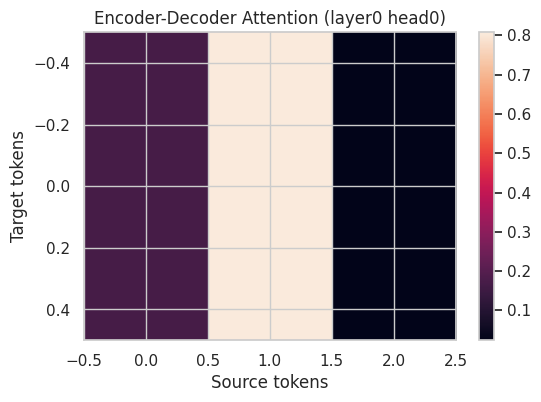

In [14]:
import matplotlib.pyplot as plt

# visualize encoder-decoder attention for a single example
ex = 'hello'
src_encoded = torch.tensor(encode_src(ex), dtype=torch.long).unsqueeze(0).to(DEVICE)
model.eval()
with torch.no_grad():
    enc_out = model.encoder(src_encoded)
    ys = torch.tensor([[TGT_V2I[TGT_BOS]]], device=DEVICE)
    ys = ys.to(DEVICE)
    tgt_mask = make_tgt_mask(ys.size(1), DEVICE)
    logits, self_attns, enc_attns = model.decoder(ys, enc_out, tgt_mask)

# enc_attns is a list of layer attentions: each is (B, heads, tgt_len, src_len)
layer_idx = 0
head_idx = 0
attn = enc_attns[layer_idx][0][head_idx].cpu().numpy()
plt.figure(figsize=(6,4))
plt.imshow(attn, aspect='auto')
plt.title('Encoder-Decoder Attention (layer0 head0)')
plt.xlabel('Source tokens')
plt.ylabel('Target tokens')
plt.colorbar(); plt.show()